Class Weights: [0.94647205 1.1130186  1.0414994  1.0332005  0.9936143  0.9676617
 0.9099415  0.94647205 1.0942335  0.9228944  0.9328537  1.0672153
 1.0209974  1.076072   0.95343137 1.0414994  1.025033   0.97861636]


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|██████████| 584/584 [01:51<00:00,  5.23it/s, loss=0.614]


Epoch 1 - Train Acc: 0.4355, Val Acc: 0.7444, Val Loss: 0.8728


Training Epoch 2: 100%|██████████| 584/584 [01:53<00:00,  5.15it/s, loss=1.88]


Epoch 2 - Train Acc: 0.8329, Val Acc: 0.7911, Val Loss: 0.6743


Training Epoch 3: 100%|██████████| 584/584 [01:53<00:00,  5.15it/s, loss=0.748]


Epoch 3 - Train Acc: 0.8892, Val Acc: 0.8156, Val Loss: 0.7010


Training Epoch 4: 100%|██████████| 584/584 [01:53<00:00,  5.15it/s, loss=0.0384]


Epoch 4 - Train Acc: 0.9186, Val Acc: 0.8222, Val Loss: 0.6645


Training Epoch 5: 100%|██████████| 584/584 [01:53<00:00,  5.15it/s, loss=1.63]


Epoch 5 - Train Acc: 0.9299, Val Acc: 0.8156, Val Loss: 0.7479


Training Epoch 6: 100%|██████████| 584/584 [01:53<00:00,  5.15it/s, loss=0.0086]


Epoch 6 - Train Acc: 0.9473, Val Acc: 0.8111, Val Loss: 0.8415


Training Epoch 7: 100%|██████████| 584/584 [01:53<00:00,  5.15it/s, loss=0.297]


Epoch 7 - Train Acc: 0.9535, Val Acc: 0.8156, Val Loss: 0.8209


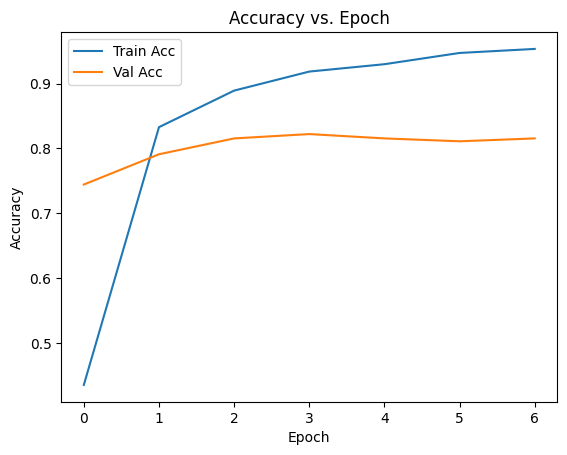

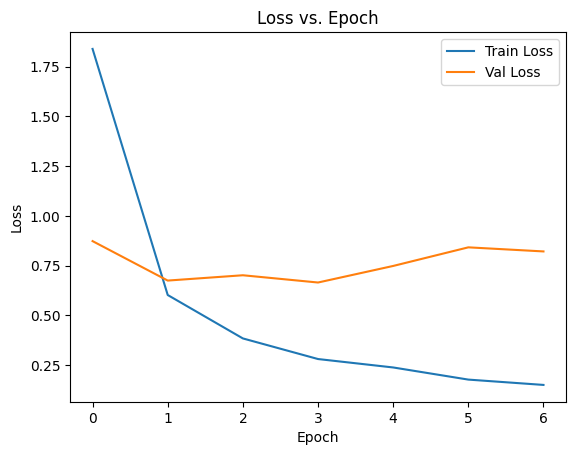

Test Loss: 0.4392
Test Report:
              precision    recall  f1-score   support

          AB       1.00      1.00      1.00        30
          AS       0.95      0.70      0.81        30
          DI       0.73      0.73      0.73        30
          DS       0.78      0.83      0.81        30
          ED       0.94      0.97      0.95        30
          EI       0.85      0.93      0.89        30
          EM       0.68      0.93      0.79        30
          ET       1.00      1.00      1.00        30
          FA       0.81      0.83      0.82        30
          IS       0.94      0.97      0.95        30
          MA       0.90      0.90      0.90        30
          NP       0.86      0.83      0.85        30
          PU       1.00      0.97      0.98        30
          SB       0.93      0.83      0.88        30
          SI       0.96      0.87      0.91        30
          SS       0.88      0.73      0.80        30
          US       0.87      0.87      0.87       

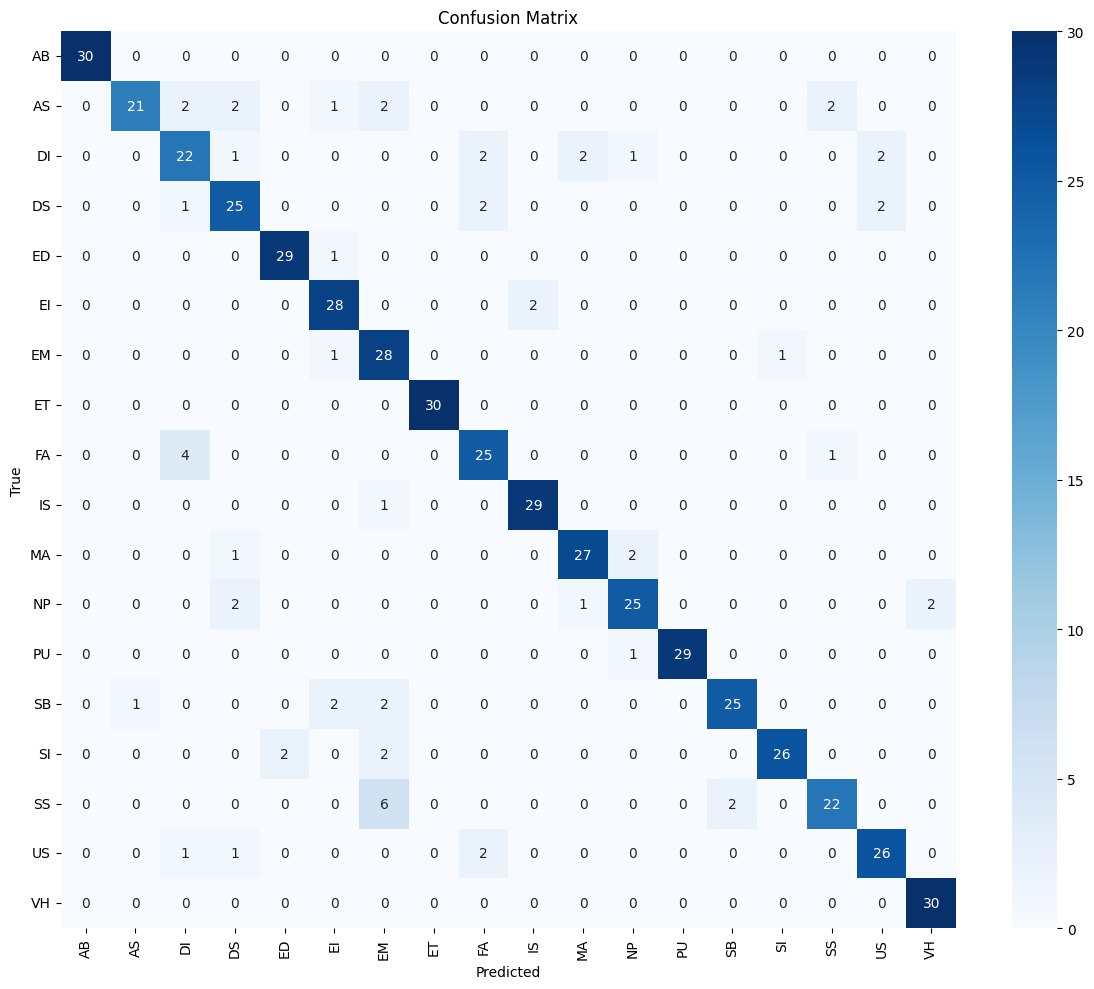

In [3]:
# Learning rate : 2e-5 Batch size : 8

import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Cihaz kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Veriyi yükle
train_df = pd.read_csv("/content/merged_output_cleaned.csv").dropna(subset=["Sentence", "Stage"])
val_df = pd.read_csv("/content/evaluation.csv").dropna(subset=["Sentence", "Stage"])
test_df = pd.read_csv("/content/test_data.csv").dropna(subset=["Sentence", "Stage"])

# Label encode
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["Stage"])
val_df["label"] = label_encoder.transform(val_df["Stage"])
test_df["label"] = label_encoder.transform(test_df["Stage"])

# Dataset sınıfı
class SchemaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Tokenizer ve veriler
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_dataset = SchemaDataset(train_df["Sentence"].tolist(), train_df["label"].tolist(), tokenizer)
val_dataset = SchemaDataset(val_df["Sentence"].tolist(), val_df["label"].tolist(), tokenizer)
test_dataset = SchemaDataset(test_df["Sentence"].tolist(), test_df["label"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

# Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df["label"]), y=train_df["label"])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights.cpu().numpy())

# Model, optimizer, loss, scheduler
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_encoder.classes_)).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Eğitim döngüsü
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(7):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    train_accuracies.append(train_acc)
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_losses[-1]:.4f}")
    scheduler.step(val_losses[-1])

# Accuracy plot
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

# Test değerlendirme
model.eval()
test_loss, test_preds, true_labels = 0, [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        test_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

# Classification report
print("Test Report:")
print(classification_report(true_labels, test_preds, labels=list(range(len(label_encoder.classes_))), target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(true_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Class Weights: [0.94647205 1.1130186  1.0414994  1.0332005  0.9936143  0.9676617
 0.9099415  0.94647205 1.0942335  0.9228944  0.9328537  1.0672153
 1.0209974  1.076072   0.95343137 1.0414994  1.025033   0.97861636]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|██████████| 584/584 [01:53<00:00,  5.13it/s, loss=0.74]


Epoch 1 - Train Acc: 0.6410, Val Acc: 0.7956, Val Loss: 0.7725


Training Epoch 2: 100%|██████████| 584/584 [01:53<00:00,  5.14it/s, loss=0.113]


Epoch 2 - Train Acc: 0.8518, Val Acc: 0.7933, Val Loss: 0.6796


Training Epoch 3: 100%|██████████| 584/584 [01:53<00:00,  5.15it/s, loss=0.239]


Epoch 3 - Train Acc: 0.8978, Val Acc: 0.8067, Val Loss: 0.7376


Training Epoch 4: 100%|██████████| 584/584 [01:53<00:00,  5.14it/s, loss=0.0482]


Epoch 4 - Train Acc: 0.9175, Val Acc: 0.8289, Val Loss: 0.5981


Training Epoch 5: 100%|██████████| 584/584 [01:53<00:00,  5.13it/s, loss=0.0262]


Epoch 5 - Train Acc: 0.9396, Val Acc: 0.8067, Val Loss: 0.7595


Training Epoch 6: 100%|██████████| 584/584 [01:53<00:00,  5.13it/s, loss=0.0275]


Epoch 6 - Train Acc: 0.9381, Val Acc: 0.8378, Val Loss: 0.6469


Training Epoch 7: 100%|██████████| 584/584 [01:53<00:00,  5.13it/s, loss=0.424]


Epoch 7 - Train Acc: 0.9462, Val Acc: 0.8444, Val Loss: 0.6642


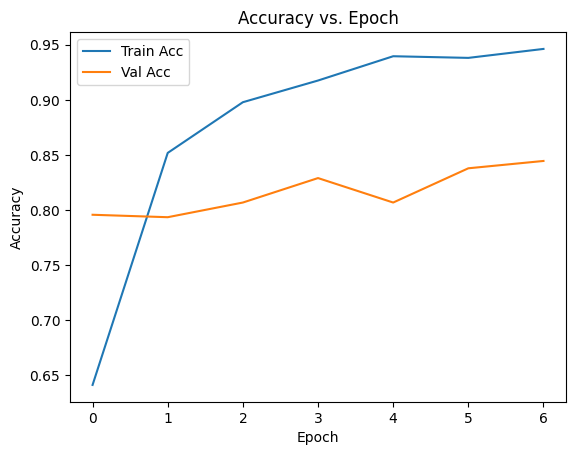

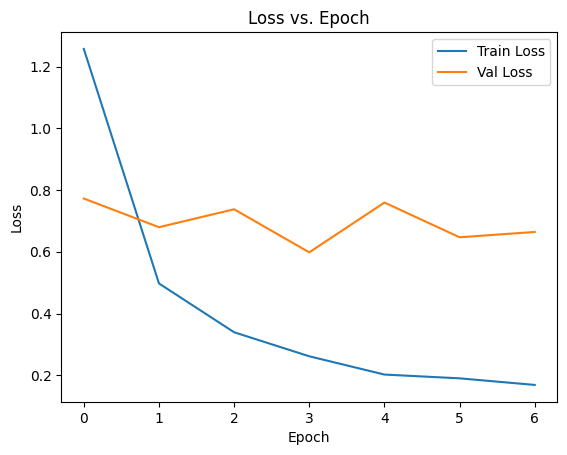

Test Loss: 0.4496
Test Report:
              precision    recall  f1-score   support

          AB       0.94      1.00      0.97        30
          AS       0.86      0.80      0.83        30
          DI       0.88      0.73      0.80        30
          DS       0.85      0.77      0.81        30
          ED       0.85      0.97      0.91        30
          EI       0.87      0.87      0.87        30
          EM       0.89      0.80      0.84        30
          ET       0.97      0.93      0.95        30
          FA       0.75      0.90      0.82        30
          IS       0.94      0.97      0.95        30
          MA       0.86      0.83      0.85        30
          NP       0.90      0.87      0.88        30
          PU       1.00      0.90      0.95        30
          SB       0.85      0.93      0.89        30
          SI       0.93      0.87      0.90        30
          SS       0.94      0.97      0.95        30
          US       0.74      0.83      0.78       

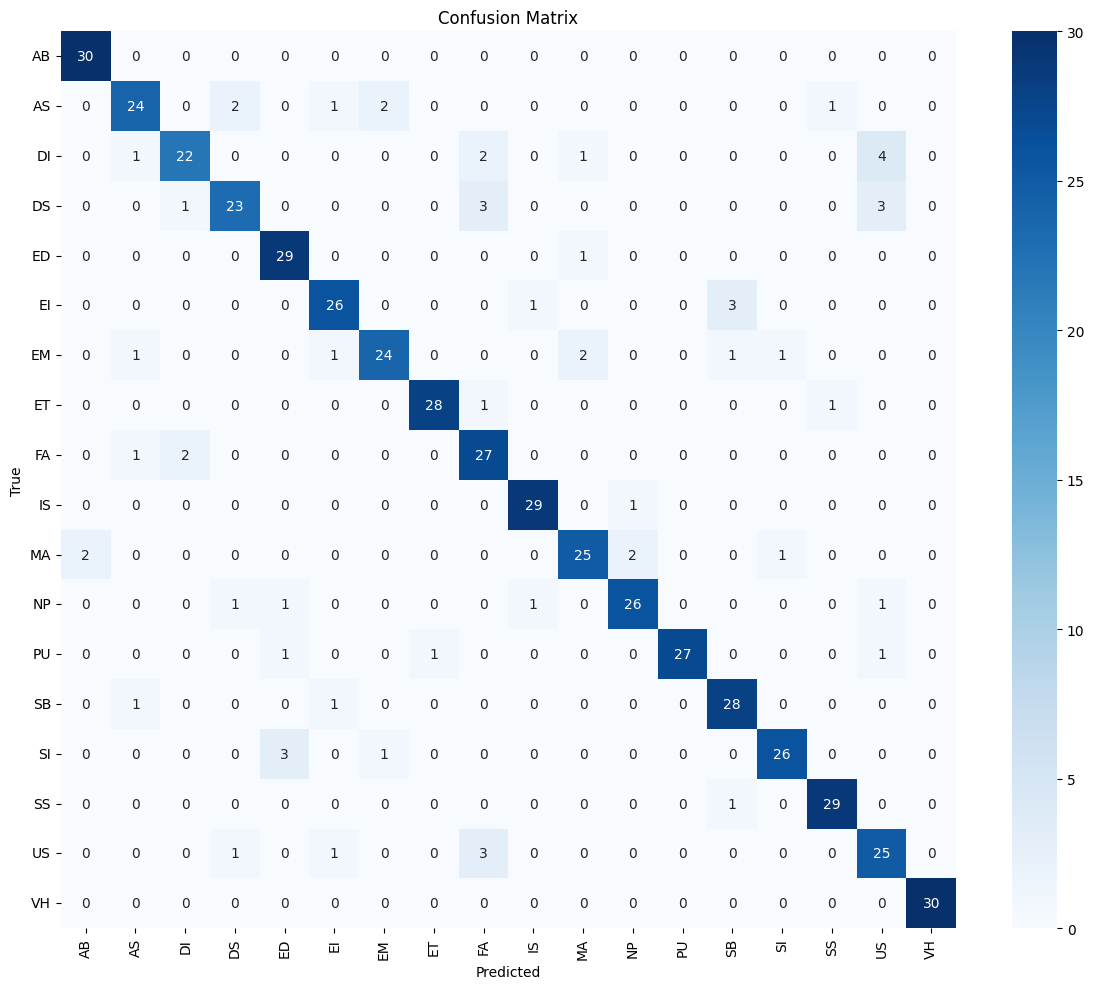

In [4]:
# Learning rate : 3e-5 Batch size : 8

import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Cihaz kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Veriyi yükle
train_df = pd.read_csv("/content/merged_output_cleaned.csv").dropna(subset=["Sentence", "Stage"])
val_df = pd.read_csv("/content/evaluation.csv").dropna(subset=["Sentence", "Stage"])
test_df = pd.read_csv("/content/test_data.csv").dropna(subset=["Sentence", "Stage"])

# Label encode
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["Stage"])
val_df["label"] = label_encoder.transform(val_df["Stage"])
test_df["label"] = label_encoder.transform(test_df["Stage"])

# Dataset sınıfı
class SchemaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Tokenizer ve veriler
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_dataset = SchemaDataset(train_df["Sentence"].tolist(), train_df["label"].tolist(), tokenizer)
val_dataset = SchemaDataset(val_df["Sentence"].tolist(), val_df["label"].tolist(), tokenizer)
test_dataset = SchemaDataset(test_df["Sentence"].tolist(), test_df["label"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

# Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df["label"]), y=train_df["label"])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights.cpu().numpy())

# Model, optimizer, loss, scheduler
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_encoder.classes_)).to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Eğitim döngüsü
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(7):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    train_accuracies.append(train_acc)
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_losses[-1]:.4f}")
    scheduler.step(val_losses[-1])

# Accuracy plot
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

# Test değerlendirme
model.eval()
test_loss, test_preds, true_labels = 0, [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        test_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

# Classification report
print("Test Report:")
print(classification_report(true_labels, test_preds, labels=list(range(len(label_encoder.classes_))), target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(true_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()